<a href="https://colab.research.google.com/github/dhyan1999/DL_ML/blob/master/Caltech256_Resnet50_DataAugmentation%2BEncoderDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install patool pyunpack
import pyunpack
pyunpack.Archive("/content/drive/MyDrive/Caltech256.rar").extractall("/content/dataset")

     |████████████████████████████████| 81kB 3.8MB/s 


In [ ]:
import os
import math

os.mkdir("caltech_test") 

for cat in os.listdir("/content/dataset/Caltech256/"):
  imgs = os.listdir("/content/dataset/Caltech256/"+cat) 
  test_imgs = imgs[30:len(imgs)]
  for t_img in test_imgs: 
    os.rename("/content/dataset/Caltech256/"+cat+"/"+t_img, "caltech_test/"+cat+"/"+t_img)

In [ ]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)

**Preparing data for feature extraction**

In [ ]:
# import cv2
from keras.applications.resnet50 import preprocess_input 
from keras.preprocessing.image import ImageDataGenerator
train_gen_autoencoder = ImageDataGenerator(rescale=1./255) 
train_flow = train_gen_autoencoder.flow_from_directory("/content/dataset/Caltech256/", target_size=(256, 256), batch_size=60,class_mode=None)
valid_flow = train_gen_autoencoder.flow_from_directory("caltech_test/", target_size=(256, 256), batch_size=60,class_mode=None)

Found 7680 images belonging to 256 classes.
Found 22100 images belonging to 256 classes.


**Importing necessary library**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [ ]:
model = models.Sequential()

# Encoder layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2), padding='same') )

# Decoder Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.UpSampling2D((2, 2)) )

model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same') )

model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
model.fit_generator(fixed_generator(train_flow), epochs=5,steps_per_epoch=7710//128, validation_steps=22897//128,validation_data = fixed_generator(valid_flow) )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
60/60 [==============================] - 48s 789ms/step - loss: 0.7315 - val_loss: 0.7285
Epoch 2/5
60/60 [==============================] - 49s 834ms/step - loss: 0.7280 - val_loss: 0.7255
Epoch 3/5
60/60 [==============================] - 47s 800ms/step - loss: 0.7251 - val_loss: 0.7223
Epoch 4/5
60/60 [==============================] - 49s 832ms/step - loss: 0.7219 - val_loss: 0.7199
Epoch 5/5
60/60 [==============================] - 48s 820ms/step - loss: 0.7192 - val_loss: 0.7168


In [ ]:
from keras.applications.resnet50 import preprocess_input # make sure to match original model's preprocessing function

train_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)
train_flow = train_gen.flow_from_directory("/content/dataset/Caltech256/", target_size=(256, 256), batch_size=130, subset="training")
valid_flow = train_gen.flow_from_directory("/content/dataset/Caltech256/", target_size=(256, 256), batch_size=130, subset="validation")

Found 6144 images belonging to 256 classes.
Found 1536 images belonging to 256 classes.


In [ ]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_flow = test_gen.flow_from_directory("caltech_test", target_size=(256, 256), batch_size=30)

Found 22100 images belonging to 256 classes.


In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.models import Model


res = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)) 

for layer in res.layers: 
  layer.trainable = False

x = res.output 
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='softmax')(x)

model = Model(res.input, x) 
opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 

model.summary() 

94773248/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
history = model.fit_generator(train_flow, epochs=100, validation_data=valid_flow) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
48/48 [==============================] - 34s 640ms/step - loss: 5.2065 - accuracy: 0.1025 - val_loss: 2.4864 - val_accuracy: 0.6055
Epoch 2/100
48/48 [==============================] - 30s 613ms/step - loss: 2.2103 - accuracy: 0.5257 - val_loss: 1.5412 - val_accuracy: 0.7233
Epoch 3/100
48/48 [==============================] - 30s 613ms/step - loss: 1.4250 - accuracy: 0.6920 - val_loss: 1.1940 - val_accuracy: 0.7493
Epoch 4/100
48/48 [==============================] - 29s 604ms/step - loss: 1.0002 - accuracy: 0.7736 - val_loss: 1.0439 - val_accuracy: 0.7630
Epoch 5/100
48/48 [==============================] - 29s 597ms/step - loss: 0.7536 - accuracy: 0.8310 - val_loss: 0.9538 - val_accuracy: 0.7708
Epoch 6/100
48/48 [==============================] - 29s 606ms/step - loss: 0.6335 - accuracy: 0.8643 - val_loss: 0.8896 - val_accuracy: 0.7845
Epoch 7/100
48/48 [==============================] - 29s 599ms/step - loss: 0.4936 - accuracy: 0.8890 - val_loss: 0.8559 - val_accuracy:

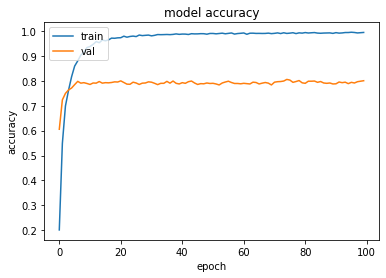

<Figure size 432x288 with 0 Axes>

In [ ]:
import keras
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("performance_caltech256.png")